# <a id='home'>Table of Contents</a>

<a href='#section1'>1. Data Quering from MySQL and Processing using R</a>

<a href='#section2'>2. Data Analysis and Visualization using ggplot2</a>

In [11]:
# Load Packages

library(readr)
library(plyr)
library(dplyr)
library(ggplot2)
library(corrplot)
library(scales)
library(ggrepel)
library(mongolite)
library(RMySQL)
library(DBI)
readRenviron(".Renviron")

## <a id='section1'>1. Data Quering from MySQL and Processing using R</a>

<a href='#home'>Home</a>

In [12]:
# Create MySQL connection
con = dbConnect(
  RMySQL::MySQL(),
  dbname = "nyc_crime",
  host = "localhost",
  port = 3306,
  user = Sys.getenv("MYSQL_USER"),
  password = Sys.getenv("MYSQL_PASSWORD")
)

In [13]:
# Import CSV and create dataframe using readr
df = dbReadTable(con, "arrests")

Warning message in .local(conn, statement, ...):
“Decimal MySQL column 16 imported as numeric”
Warning message in .local(conn, statement, ...):
“Decimal MySQL column 17 imported as numeric”


In [14]:
# View first few rows of df
head(df)

,arrest_key,arrest_date,pd_cd,pd_desc,ky_cd,ofns_desc,law_code,law_cat_cd,arrest_boro,arrest_precinct,jurisdiction_code,age_group,perp_sex,perp_race,x_coord_cd,y_coord_cd,latitude,longitude
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,9926901,2006-01-01,511,"CONTROLLED SUBSTANCE, POSSESSION 7",235,DANGEROUS DRUGS,PL 2200300,M,K,60,2,<18,M,WHITE HISPANIC,983461.0,148710.0,40.57486,-74.00284
2,9926902,2006-01-01,793,WEAPONS POSSESSION 3,118,DANGEROUS WEAPONS,PL 2650203,F,K,77,0,25-44,M,BLACK,1000389.0,184624.0,40.67342,-73.94182
3,9926903,2006-01-01,793,WEAPONS POSSESSION 3,118,DANGEROUS WEAPONS,PL 2650204,F,K,75,2,25-44,M,BLACK,1016133.0,178623.0,40.65691,-73.88509
4,9926904,2006-01-01,567,"MARIJUANA, POSSESSION 4 & 5",235,DANGEROUS DRUGS,PL 2211001,M,K,71,0,18-24,M,BLACK,995164.0,180080.0,40.66096,-73.96066
5,9926993,2006-01-01,511,"CONTROLLED SUBSTANCE, POSSESSION 7",235,DANGEROUS DRUGS,PL 2200300,M,M,7,0,25-44,M,WHITE,987536.0,202083.0,40.72136,-73.98815
6,9926995,2006-01-01,567,"MARIJUANA, POSSESSION 4 & 5",235,DANGEROUS DRUGS,PL 2211001,M,M,7,0,25-44,M,WHITE,987350.0,201914.0,40.72089,-73.98882


In [15]:
# Remove all rows with NAs in any column
df = na.omit(df)

In [16]:
# Change data types
df$arrest_date = as.Date(df$arrest_date, format = '%Y-%m-%d')

In [18]:
# Create new columns for Year, Month, Day
df$arrest_year = format(as.Date(df$arrest_date, format = "%Y-%m-%d"), "%Y")
df$arrest_month = format(as.Date(df$arrest_date, format = "%Y-%m-%d"), "%m")
df$arrest_day = format(as.Date(df$arrest_date, format = "%Y-%m-%d"), "%d")

In [19]:
# Change data types for Year, Month, Day
df$arrest_year = as.integer(df$arrest_year)
df$arrest_month = as.integer(df$arrest_month)
df$arrest_day = as.integer(df$arrest_day)

In [20]:
# Order df by ARREST_KEY descending
df = df[rev( order(df$arrest_key) ),]

In [21]:
# There are 85 different values of OFNS_DESC
length(unique(df$ofns_desc))

[1] 87

In [26]:
# Reducing crime categories for simpler reporting
# THEFT_FRAUD
THEFT = c("BURGLARY","PETIT LARCENY","OFFENSES INVOLVING FRAUD","THEFT OF SERVICES","POSSESSION OF STOLEN PROPERTY 5","THEFT-FRAUD",
          "OTHER OFFENSES RELATED TO THEF","FRAUDULENT ACCOSTING","ROBBERY","GRAND LARCENY OF MOTOR VEHICLE",
          "POSSESSION OF STOLEN PROPERTY","GRAND LARCENY","FORGERY","BURGLAR'S TOOLS","FRAUDS","OTHER OFFENSES RELATED TO THEFT",
          "JOSTLING","CRIMINAL TRESPASS")
df$category[df$ofns_desc %in% THEFT] = "THEFT & FRAUD"

# DRUGS
DRUGS = c("DANGEROUS DRUGS","LOITERING FOR DRUG PURPOSES","UNDER THE INFLUENCE, DRUGS")
df$category[df$ofns_desc %in% DRUGS] = "DRUGS"

# WEAPONS
WEAPONS = c("DANGEROUS WEAPONS","UNLAWFUL POSS. WEAP. ON SCHOOL","UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS")
df$category[df$ofns_desc %in% WEAPONS] = "WEAPONS"

# ASSAULT
ASSAULT = c("FELONY ASSAULT","ASSAULT 3 & RELATED OFFENSES")
df$category[df$ofns_desc %in% ASSAULT] = "ASSAULT"

# SEXUAL_ASSAULT
SEXUAL_ASSAULT = c("RAPE","SEX CRIMES","FORCIBLE TOUCHING")
df$category[df$ofns_desc %in% SEXUAL_ASSAULT] = "SEXUAL ASSAULT"

# TRAFFIC
TRAFFIC = c("INTOXICATED & IMPAIRED DRIVING","VEHICLE AND TRAFFIC LAWS","MOVING INFRACTIONS","PARKING OFFENSES",
            "INTOXICATED/IMPAIRED DRIVING","OTHER TRAFFIC INFRACTION", "UNAUTHORIZED USE OF A VEHICLE 3 (UUV)",
            "UNAUTHORIZED USE OF A VEHICLE")
df$category[df$ofns_desc %in% TRAFFIC] = "TRAFFIC"

# MURDER
MURDER = c("MURDER & NON-NEGL. MANSLAUGHTE", "MURDER & NON-NEGL. MANSLAUGHTER", "HOMICIDE-NEGLIGENT,UNCLASSIFIED", 
           "HOMICIDE-NEGLIGENT-VEHICLE","HOMICIDE-NEGLIGENT,UNCLASSIFIE")
df$category[df$ofns_desc %in% MURDER] = "MURDER"

# CHILDREN
CHILDREN = c("KIDNAPPING", "CHILD ABANDONMENT/NON SUPPORT 1", "KIDNAPPING & RELATED OFFENSES", "OFFENSES RELATED TO CHILDREN",
             "CHILD ABANDONMENT/NON SUPPORT")
df$category[df$ofns_desc %in% CHILDREN] = "CHILDREN"

# OTHER
ALL_CAT = c(THEFT, DRUGS, WEAPONS, ASSAULT, SEXUAL_ASSAULT, MURDER, CHILDREN, TRAFFIC)
df$category[!df$ofns_desc %in% ALL_CAT] = "OTHER"

In [27]:
# CATEGORY column will contain only 9 distinct values
unique(df$category)

[1] "OTHER"          "ASSAULT"        "THEFT & FRAUD"  "TRAFFIC"       
[5] "WEAPONS"        "DRUGS"          "SEXUAL ASSAULT" "MURDER"        
[9] "CHILDREN"

In [28]:
# Drop unnecessary columns
df = within(df, rm(pd_cd, ky_cd, law_code, jurisdiction_code))

In [30]:
# Note how age cohorts are erroneously entered
unique(df$age_group)

[1] "18-24"   "25-44"   "45-64"   "<18"     "65+"     "UNKNOWN"

## <a id='section1'>Data Analysis and Visualization using ggplot2</a>

<a href='#home'>Home</a>

`summarise()` ungrouping output (override with `.groups` argument)



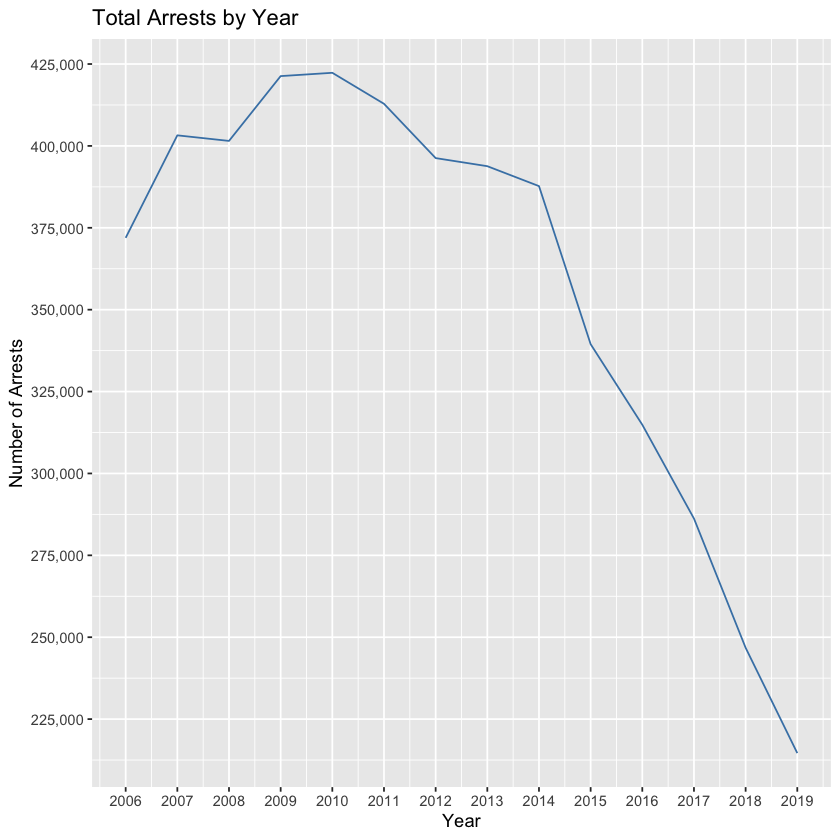

In [32]:
# Plot arrests by year using dplyr
df_arrests_year = df %>%
  group_by(arrest_year) %>%
  summarize(total_arrests = n())

df_arrests_year %>% 
  ggplot(aes(x=arrest_year, y=total_arrests)) + 
  geom_line(color="steel blue") +
  ggtitle("Total Arrests by Year") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks=seq(min(df_arrests_year$arrest_year),max(df_arrests_year$arrest_year),1))

`summarise()` ungrouping output (override with `.groups` argument)



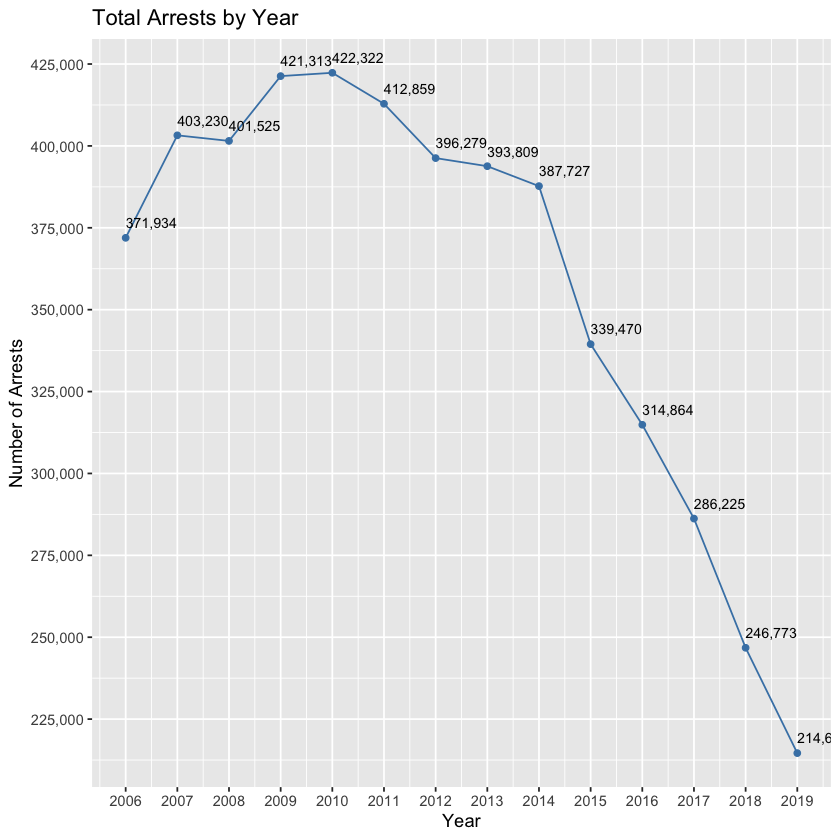

In [33]:
# We can also add labels to the graph
df_arrests_year = df %>%
  group_by(arrest_year) %>%
  summarize(total_arrests = n())

df_arrests_year %>% 
  ggplot(aes(x=arrest_year, y=total_arrests, label=total_arrests)) + 
  geom_line(color="steel blue") +
  ggtitle("Total Arrests by Year") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  #scale_y_continuous(breaks=df_arrests_year$total_arrests) +
  scale_x_continuous(breaks=seq(min(df_arrests_year$arrest_year),max(df_arrests_year$arrest_year),1)) +
  geom_text(hjust=0, vjust=-1, size=3, aes(label=scales::comma(total_arrests))) +
  geom_point(color='steel blue')

Warning message:
“Removed 1 rows containing missing values (geom_text).”


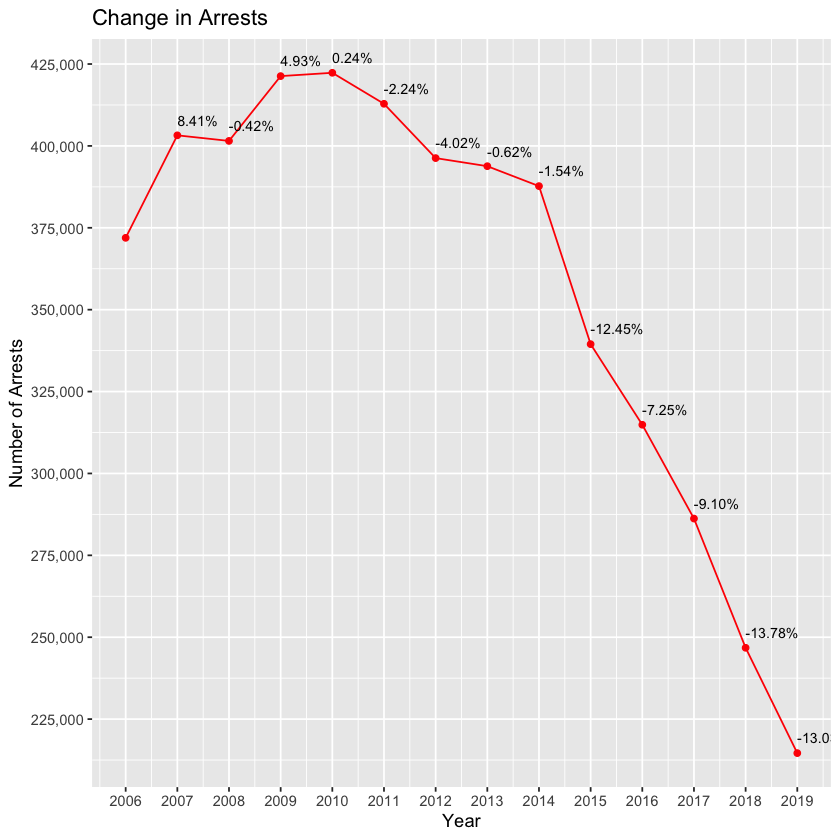

In [34]:
# Add percentage change
df_arrests_year_pc = mutate(df_arrests_year, change=(total_arrests/lag(total_arrests))-1)

df_arrests_year_pc %>% 
  ggplot(aes(x=arrest_year, y=total_arrests, label=scales::percent(change)) ) + 
  geom_line(color="red") +
  ggtitle("Change in Arrests") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks=seq(min(df_arrests_year_pc$arrest_year), max(df_arrests_year_pc$arrest_year),1)) +
  geom_text(hjust=0, vjust=-1, size=3) +
  geom_point(color='red')

`summarise()` ungrouping output (override with `.groups` argument)



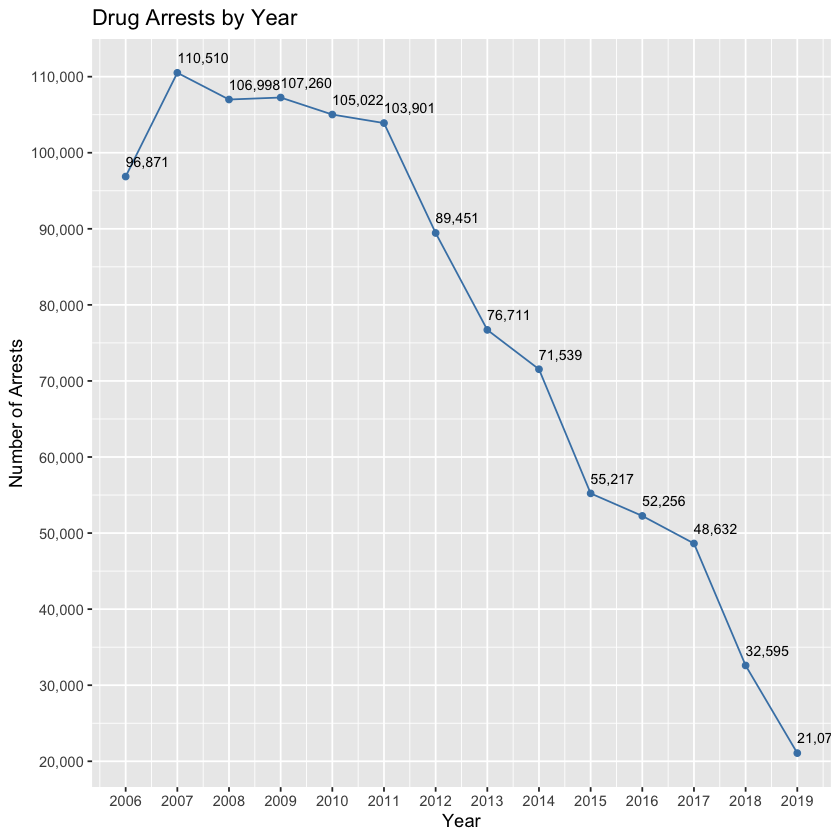

In [35]:
# Plot drug arrests for all years
df_arrests_drugs = df %>%
  filter(category == 'DRUGS') %>%
  group_by(arrest_year) %>%
  summarize(total_arrests = n())

df_arrests_drugs %>%
  ggplot(aes(x=arrest_year, y=total_arrests, label=total_arrests)) +
  geom_line(color='steel blue') +
  ggtitle("Drug Arrests by Year") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks=seq(min(df_arrests_drugs$arrest_year), max(df_arrests_drugs$arrest_year), 1)) +
  geom_text(hjust=0, vjust=-1, size=3, aes(label=scales::comma(total_arrests))) +
  geom_point(color='steel blue')

Warning message:
“Removed 1 rows containing missing values (geom_text).”


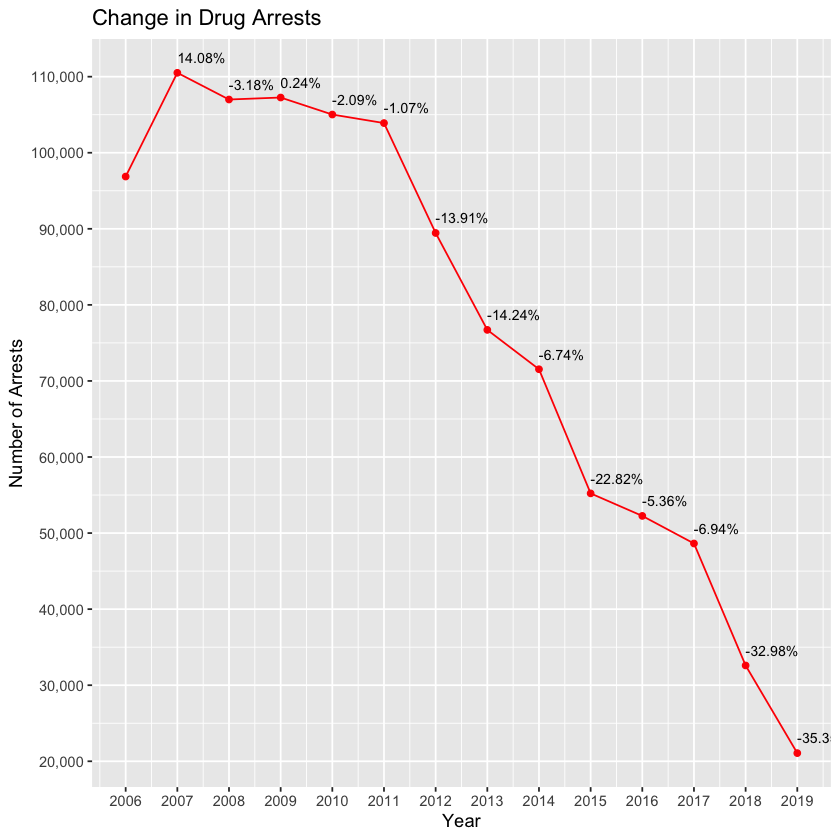

In [36]:
# Plot drug arrests percent change
df_arrests_drugs_pc = mutate(df_arrests_drugs, change=(total_arrests/lag(total_arrests))-1)

df_arrests_drugs_pc %>% 
  ggplot( aes(x=arrest_year, y=total_arrests, label=scales::percent(change))) +
  geom_line(color = 'red') +
  ggtitle("Change in Drug Arrests") +
  xlab("Year") +
  ylab("Number of Arrests") +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  scale_x_continuous(breaks=seq( min(df_arrests_drugs_pc$arrest_year), max(df_arrests_drugs_pc$total_arrests), 1)) +
  geom_text(hjust=0, vjust=-1, size=3) +
  geom_point(color='red')


`summarise()` regrouping output by 'arrest_year' (override with `.groups` argument)



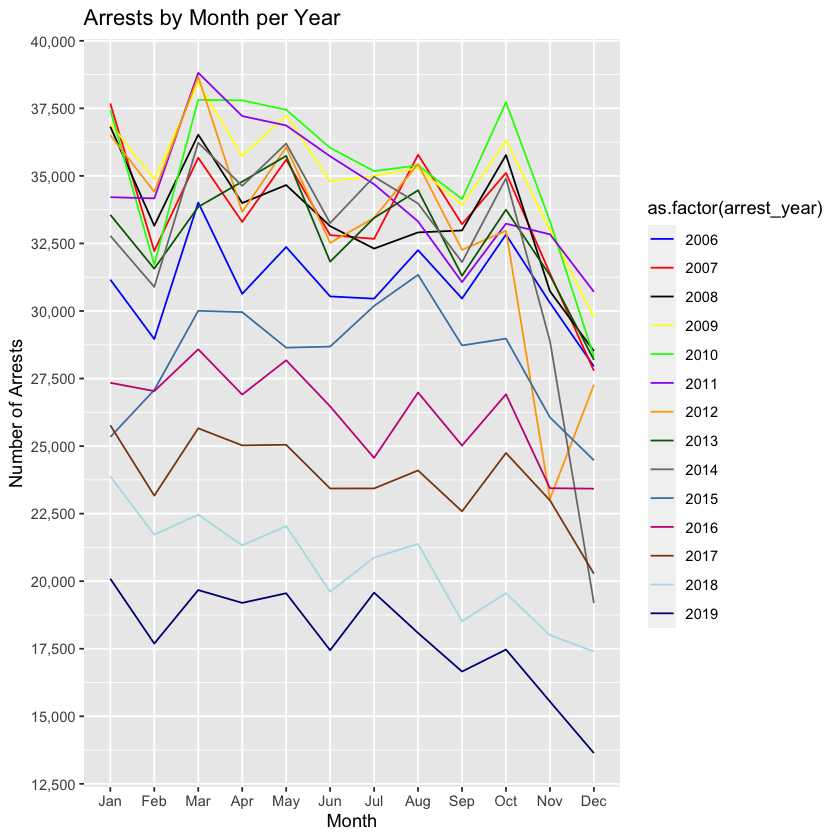

In [37]:
# Plot total arrests with line for each year
df_arrests_month_year = df %>%
  group_by(arrest_year, arrest_month) %>%
  summarize(total_arrests = n())

df_arrests_month_year = df_arrests_month_year %>%
  mutate(arrest_month = factor(month.abb[months], levels = month.abb))

df_arrests_month_year %>%
  ggplot(aes(x=arrest_month, y=total_arrests, group=arrest_year, color=as.factor(arrest_year))) +
  geom_line() +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  #geom_text() +
  ggtitle('Arrests by Month per Year') +
  xlab('Month') +
  ylab('Number of Arrests') +
  scale_color_manual(values=c('blue','red','black','yellow','green','purple','orange','dark green','gray48','steel blue',
                              'mediumvioletred','saddlebrown','powderblue','navy'))

`summarise()` ungrouping output (override with `.groups` argument)



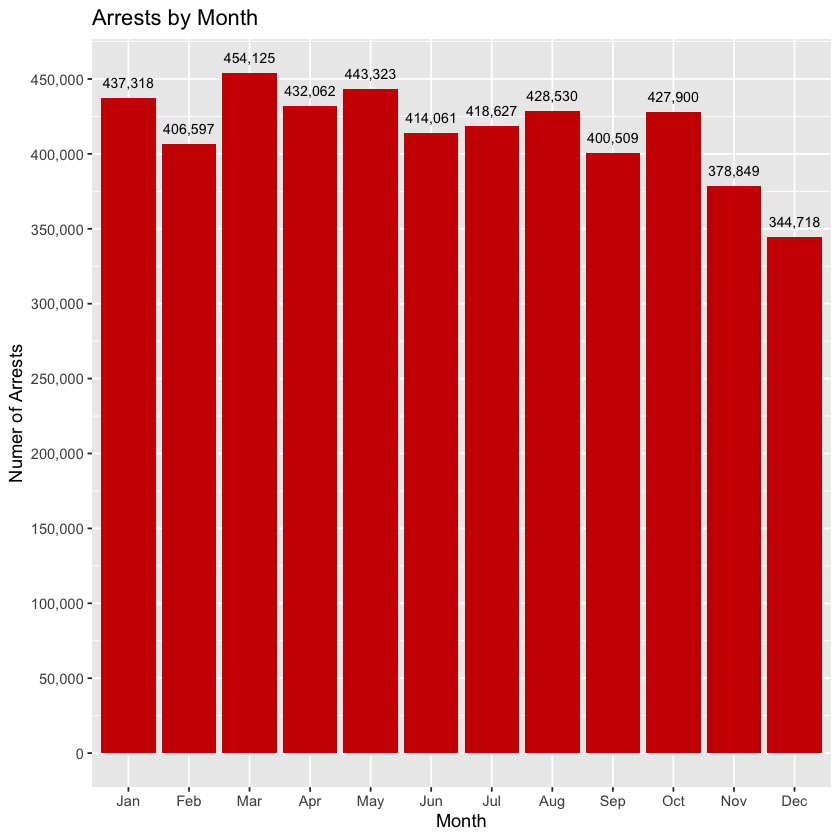

In [38]:
# Arrests by Month
df_arrests_month_name = df %>%
  group_by(arrest_month) %>%
  summarize(total_arrests = n())

df_arrests_month_name = df_arrests_month %>% 
  mutate(arrest_month = factor(month.abb[months], levels=month.abb))

df_arrests_month_name %>%
  ggplot(aes(x=arrest_month, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='red3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Arrests by Month') +
  ylab('Numer of Arrests') +
  xlab('Month')

`summarise()` ungrouping output (override with `.groups` argument)



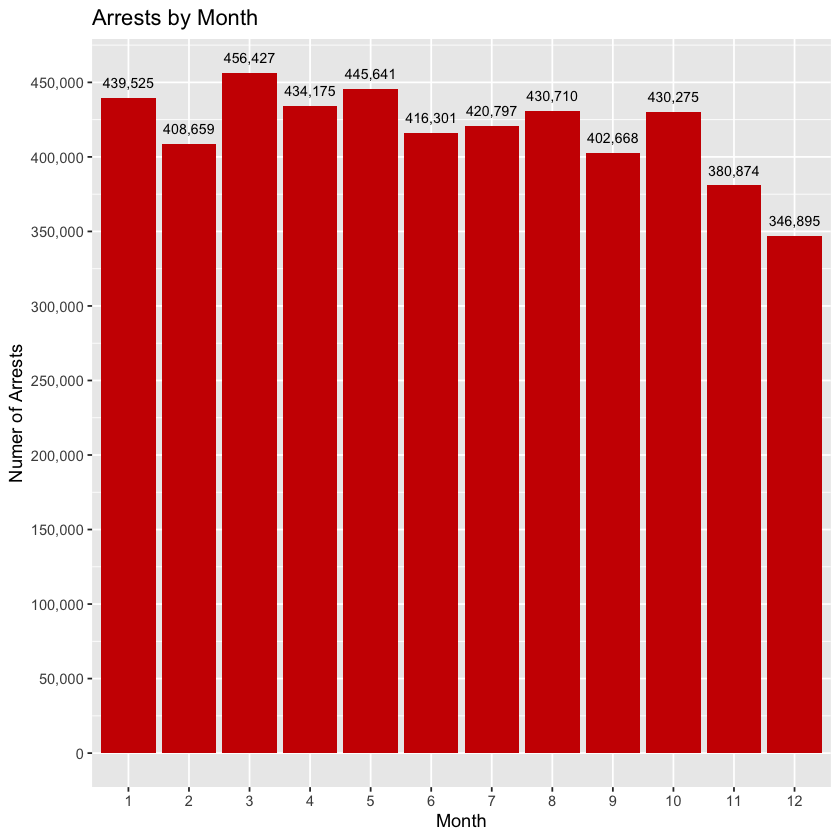

In [39]:
# or we can use the number of the month

df_arrests_month = df %>%
  group_by(arrest_month) %>%
  summarize(total_arrests = n())

df_arrests_month = df_arrests_month %>%
  mutate(arrest_month = factor(arrest_month))

df_arrests_month %>%
  ggplot(aes(x=arrest_month, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='red3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Arrests by Month') +
  ylab('Numer of Arrests') +
  xlab('Month') 

`summarise()` ungrouping output (override with `.groups` argument)



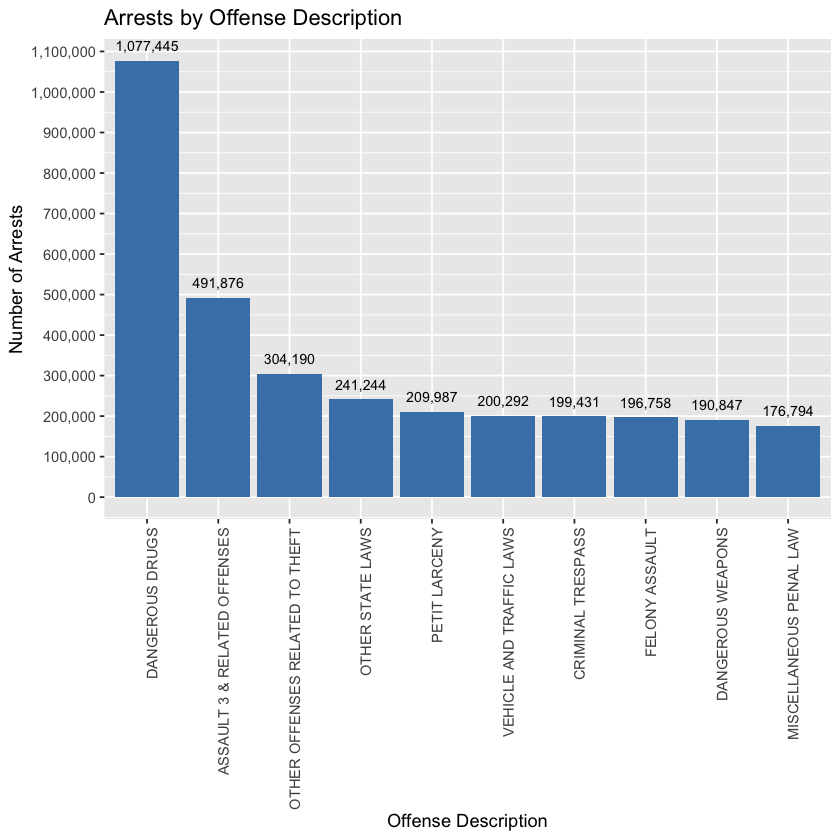

In [40]:
# Top 10 crimes by OFNS_DESC
df_top_10 = df %>%
  group_by(ofns_desc) %>%
  summarize(total_arrests = n())

df_top_10 = top_n(df_top_10, 10, total_arrests) %>%
  arrange(desc(total_arrests))

df_top_10 %>%
  ggplot(aes(x=ofns_desc, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='steel blue') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  theme(axis.text.x=element_text(angle=90,hjust=1)) +
  aes(x = reorder(ofns_desc, -total_arrests)) +
  ggtitle('Arrests by Offense Description') +
  xlab('Offense Description') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



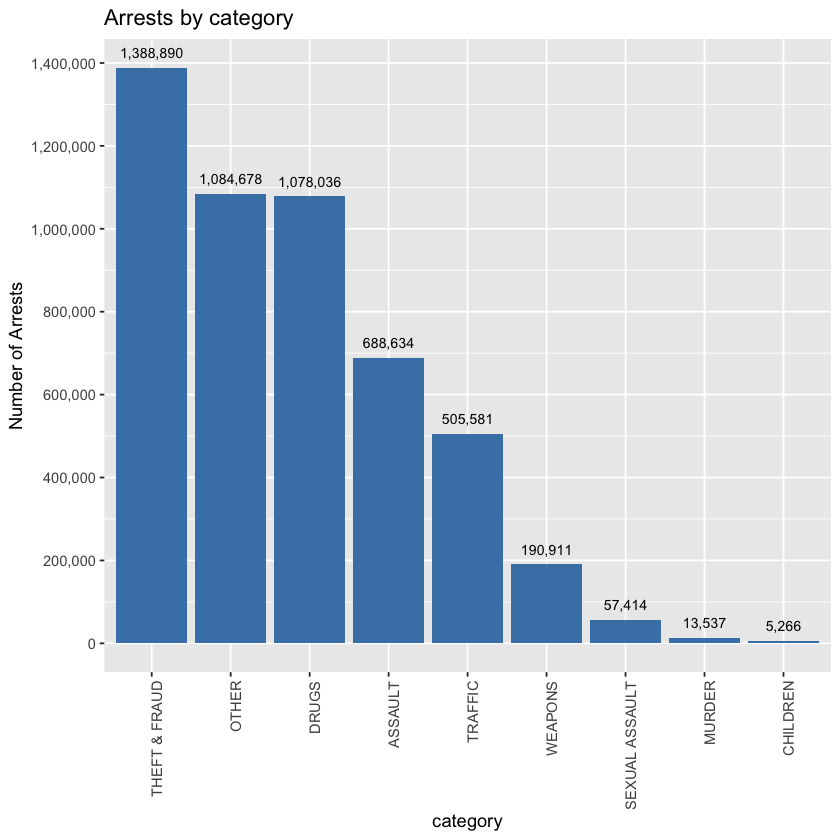

In [41]:
# Top crimes by CATEGORY
df_top_cat = df %>%
  group_by(category) %>%
  summarize(total_arrests = n())

df_top_cat = top_n(df_top_cat,length(unique(df$category)),total_arrests) %>%
  arrange(desc(total_arrests))

df_top_cat %>%
  ggplot(aes(x=category, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='steel blue') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  theme(axis.text.x=element_text(angle=90,hjust=1)) +
  aes(x=reorder(category, -total_arrests)) +
  ggtitle('Arrests by category') +
  xlab('category') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



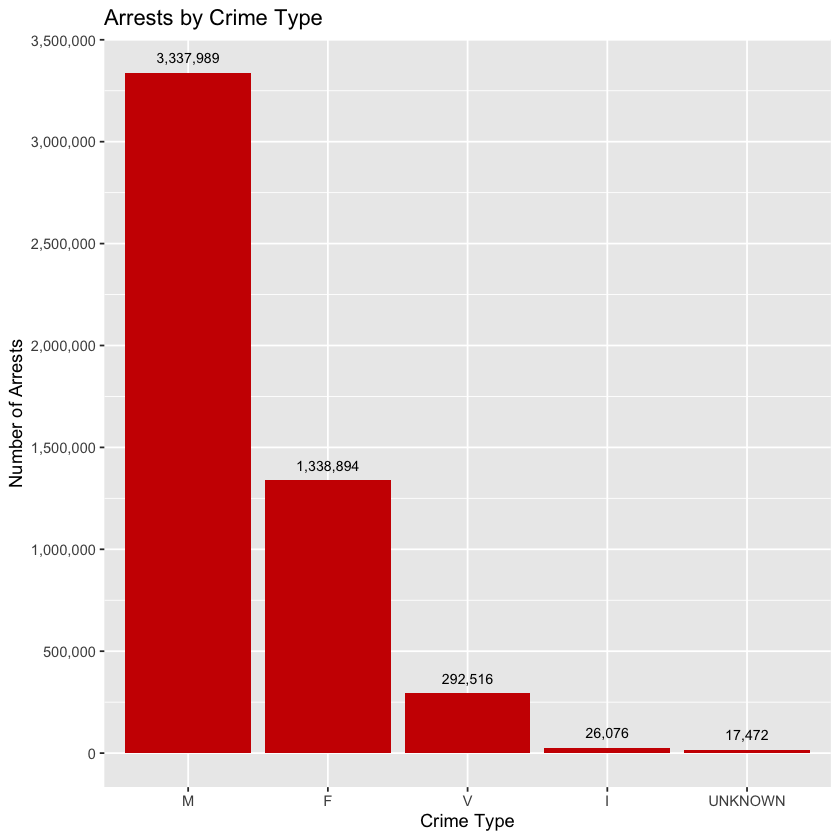

In [42]:
# Crimes by Misdemeanors, Felonies, Violations, Infractions
df_crime_type = df %>%
  group_by(law_cat_cd) %>%
  summarize(total_arrests = n())

df_crime_type %>%
  ggplot(aes(x=law_cat_cd, y=total_arrests), label=total_arrests) +
  geom_bar(stat='identity', fill='red3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  aes(x=reorder(law_cat_cd, -total_arrests)) +
  ggtitle('Arrests by Crime Type') +
  xlab('Crime Type') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



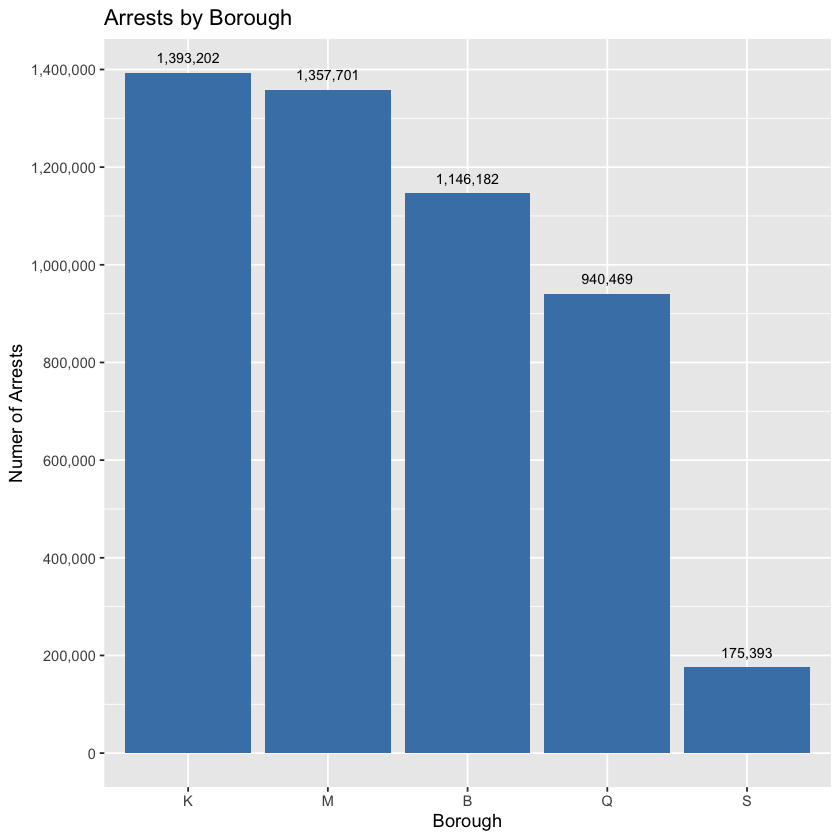

In [43]:
# Arrests by Borough
df_arrests_boro = df %>%
  group_by(arrest_boro) %>%
  summarize(total_arrests = n())

df_arrests_boro %>% 
  ggplot(aes(x=arrest_boro, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='steel blue') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  aes(x=reorder(arrest_boro, -total_arrests)) +
  ggtitle('Arrests by Borough') +
  ylab('Numer of Arrests') +
  xlab('Borough')

`summarise()` ungrouping output (override with `.groups` argument)



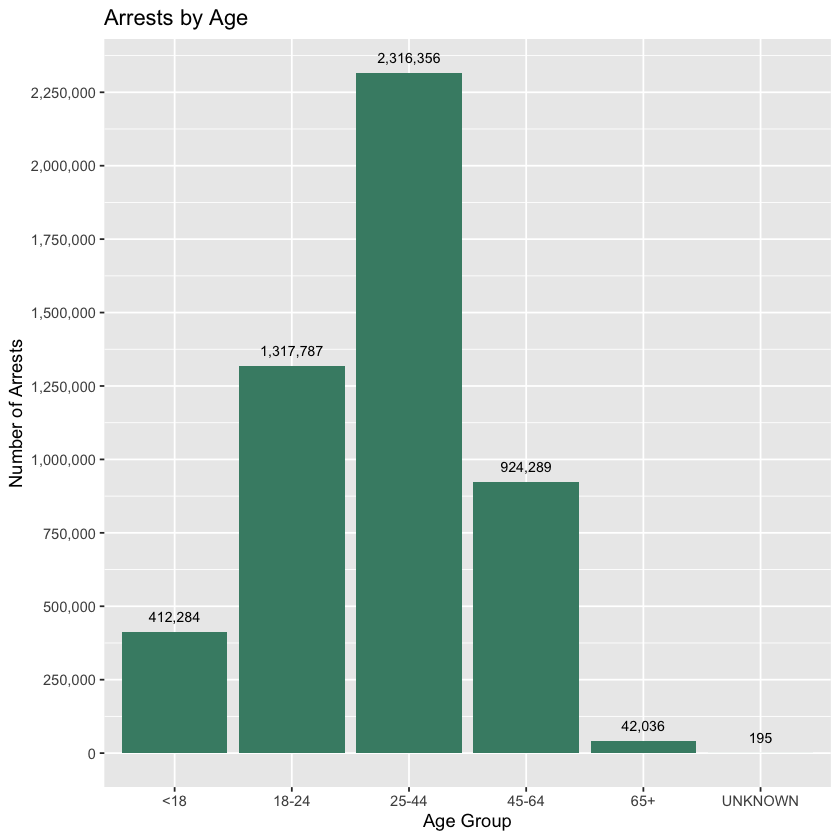

In [44]:
# Plot total arrests by age

df_arrests_age = df %>%
  group_by(age_group) %>%
  summarize(total_arrests=n())

df_arrests_age %>%
  ggplot(aes(x=age_group, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='aquamarine4') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Arrests by Age') +
  xlab('Age Group') +
  ylab('Number of Arrests')

`summarise()` ungrouping output (override with `.groups` argument)



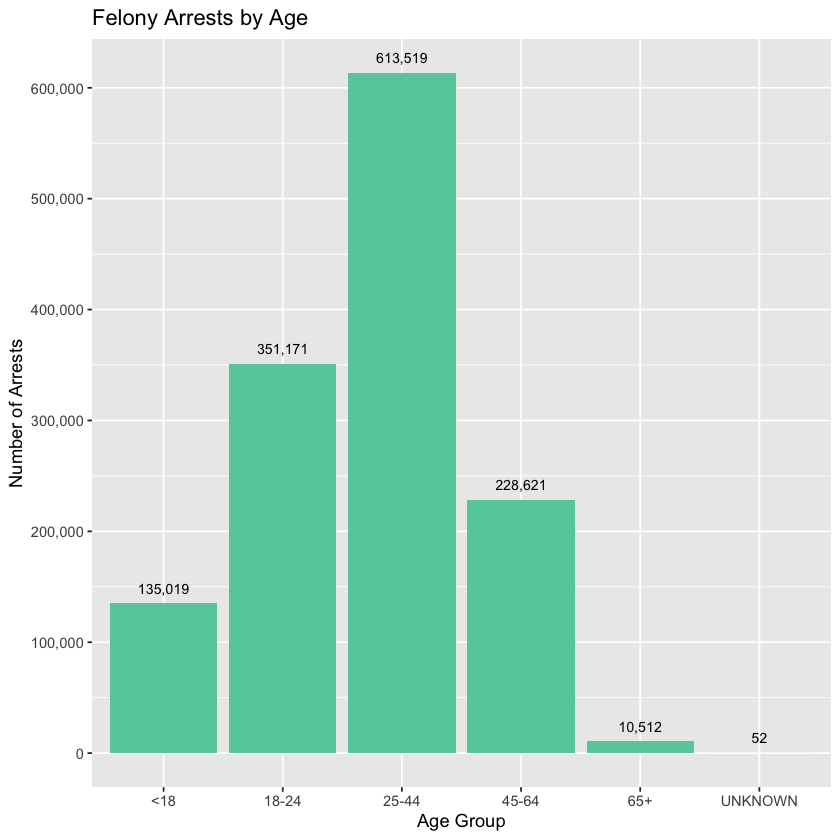

In [45]:
# Plot arrests by age for felonies

df_arrests_age_fel = df %>%
  filter(law_cat_cd == 'F') %>%
  group_by(age_group) %>%
  summarize(total_arrests=n())

df_arrests_age_fel %>%
  ggplot(aes(x=age_group, y=total_arrests, label=total_arrests)) +
  geom_bar(stat='identity', fill='aquamarine3') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('Felony Arrests by Age') +
  xlab('Age Group') +
  ylab('Number of Arrests')

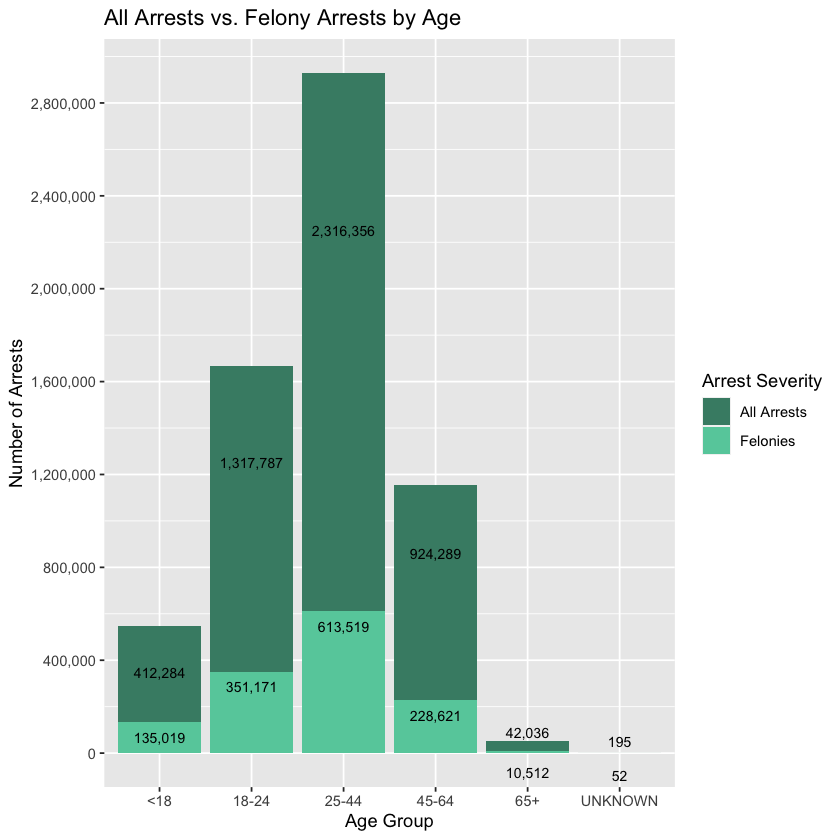

In [46]:
# Plot all arrests by age & arrests for felonies by age on same chart
df_arrests_age_comb = dplyr::bind_rows(df_arrests_age, df_arrests_age_fel, .id='id')
df_arrests_age_comb %>%
  ggplot(aes(x=age_group, y=total_arrests, fill=id, label=total_arrests)) +
  geom_bar(stat='identity') +
  scale_y_continuous(breaks=scales::breaks_extended(n=10), labels=comma) +
  #geom_text(hjust=.5, vjust=-1, size=3, aes(label=comma(total_arrests))) +
  ggtitle('All Arrests vs. Felony Arrests by Age') +
  scale_fill_manual(labels=c('All Arrests','Felonies'), values=c('aquamarine4','aquamarine3')) +
  labs(title='All Arrests vs. Felony Arrests by Age', x='Age Group', y='Number of Arrests', fill='Arrest Severity') +
  geom_text_repel(vjust=2, direction='y', segment.color='transparent', aes(label=comma(total_arrests)), size=3)

`summarise()` ungrouping output (override with `.groups` argument)



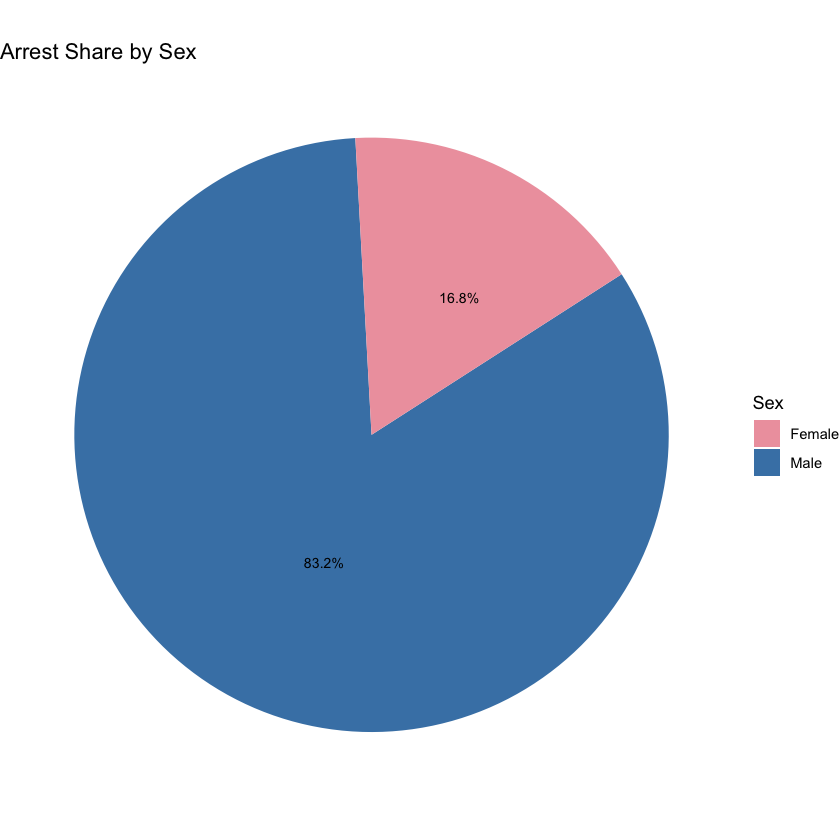

In [47]:
# Pie chart by sex
df_sex = df %>%
  group_by(perp_sex) %>%
  summarize(total_arrests = n()) %>%
  arrange(desc(total_arrests))

df_sex = df_sex %>%
  mutate(prop=total_arrests/sum(total_arrests), prop=scales::percent(prop,.10))

df_sex %>%
  ggplot(aes(x='', y=total_arrests, label=prop, fill=perp_sex)) +
  geom_bar(stat='identity') +
  coord_polar('y', start=1) +
  theme_void() +
  scale_fill_manual(labels=c('Female','Male'), values=c('lightpink2','steel blue')) +
  geom_text(hjust=0, vjust=0, size=3, aes(label=prop), color="black", position=position_stack(vjust=.5)) +
  labs(title='Arrest Share by Sex', fill='Sex')

`summarise()` ungrouping output (override with `.groups` argument)



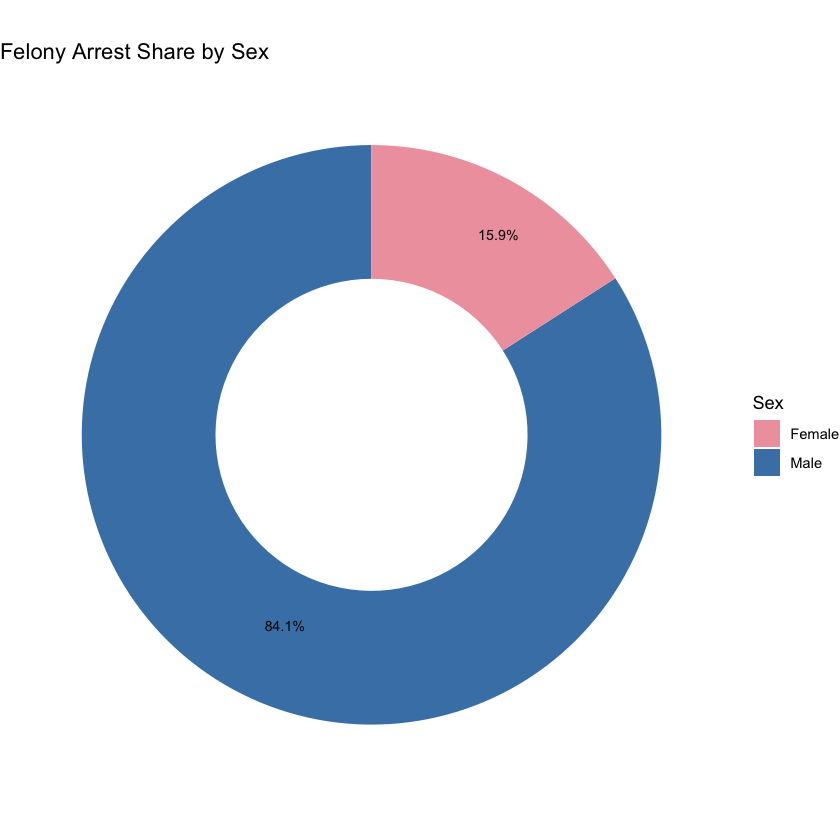

In [48]:
# Doughnut chart for felony arrests by sex
df_sex_fel = df %>%
  filter(law_cat_cd=='F') %>%
  group_by(perp_sex) %>%
  summarize(total_arrests = n()) %>%
  arrange(desc(total_arrests))

df_sex_fel = df_sex_fel %>%
  mutate(prop=total_arrests/sum(total_arrests), prop=scales::percent(prop,.10))

df_sex_fel %>%
  ggplot(aes(x=2, y=total_arrests, label=prop, fill=perp_sex)) +
  geom_bar(stat='identity') +
  coord_polar(theta='y', start=1) +
  theme_void() +
  scale_fill_manual(labels=c('Female','Male'), values=c('lightpink2','steel blue')) +
  geom_text(hjust=0, vjust=0, size=3, aes(label=prop), color="black", position=position_stack(vjust=.5)) +
  labs(title='Felony Arrest Share by Sex', fill='Sex') +
  xlim(0.5,2.5)

# 3. NoSQL

In [ ]:
# Make connection to mongoDB
#c=mongo(db='nyc_crime', collection='arrests')

In [ ]:
# Insert all documents into arrests collection
#c$insert(df)

In [ ]:
# Count shows number of documents in mongoDB
#c$count()